# DIC Phase 2
## Prof. Eric Mikida
### Yashika Nihalani, 50425015
### Ashutosh Shailesh Bhawsar, 50416025

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pystan==2.19
!pip install fbprophet

import pandas as pd
import numpy as np

import time

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import date

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import model_selection

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import activation

from sklearn.metrics import mean_squared_error, mean_absolute_error

import fbprophet
from fbprophet import Prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
btc_main = pd.read_csv('/content/drive/MyDrive/DIC Project/bitcoin_daily_data_cleaned.csv', index_col='Timestamp')

btc_data = btc_main[['Weighted_Price']]
btc_data['Weighted_Price'].fillna(method='ffill', inplace=True)
btc_data

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,Weighted_Price
Timestamp,
2011-12-31,4.47
2012-01-01,4.81
2012-01-02,5.00
2012-01-03,5.25
2012-01-04,5.21
...,...
2021-03-27,55193.36
2021-03-28,55832.96
2021-03-29,56913.99


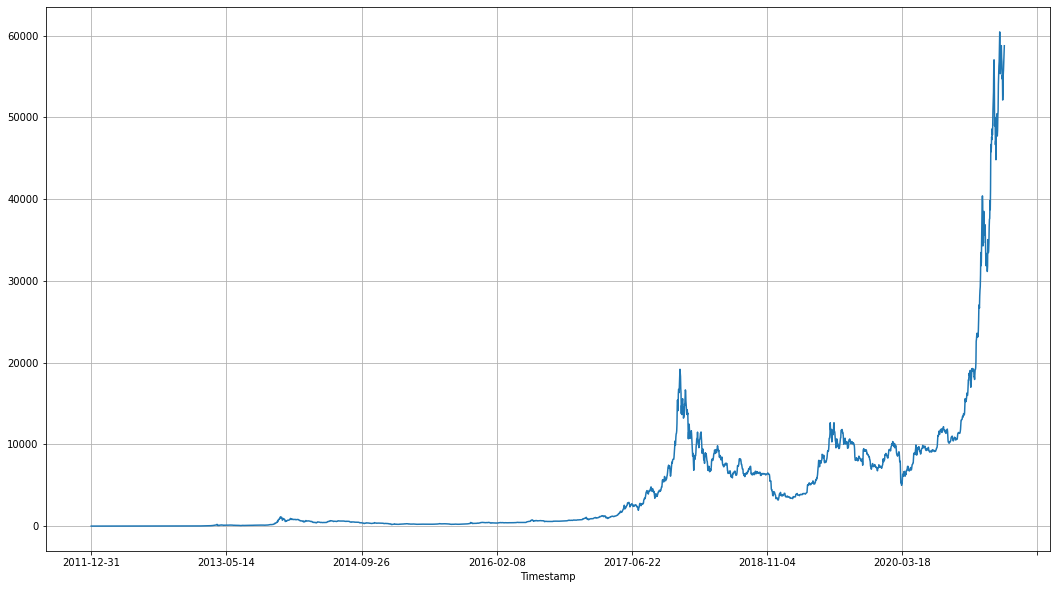

In [4]:
btc_data['Weighted_Price'].plot(figsize = (18, 10), grid = True)

# **Algorithms and their Visualizations**

##### **1) Linear Regression**

In [5]:
linear_time_unix=pd.DataFrame({})

In [6]:
linear_time_unix['Timestamp_Unix']=pd.DatetimeIndex(btc_data.index).astype(np.int64)/1000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """Entry point for launching an IPython kernel.


In [7]:
data_x = linear_time_unix[['Timestamp_Unix']]
data_y = btc_data['Weighted_Price']

In [8]:
train_x, test_x, train_y, test_y=train_test_split(data_x, data_y)

In [9]:
linear_regression_model=LinearRegression()
linear_regression_model.fit(train_x, train_y)

LinearRegression()

Text(0.5, 1.0, 'Fitted model vs actual price')

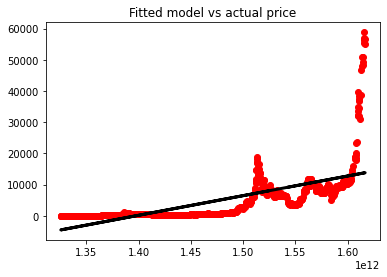

In [10]:
plt.scatter(test_x, test_y, color='red')
plt.plot(test_x, linear_regression_model.predict(test_x), color='black',linewidth=3)
plt.title('Fitted model vs actual price')

In [11]:
print('Score for Linear Regression Model : ',linear_regression_model.score(test_x, test_y))

Score for Linear Regression Model :  0.41431678203925537


##### **2) KNN Regressor**

In [12]:
df1=pd.DataFrame(btc_main,columns=['Open','Close','Volume_BTC', 'Volume_Currency', 'Weighted_Price'])
df1=df1.dropna()
df1

,Open,Close,Volume_BTC,Volume_Currency,Weighted_Price
Timestamp,,,,,
2011-12-31,4.39,4.58,23.83,106.33,4.47
2012-01-01,4.58,5.00,7.20,35.26,4.81
2012-01-02,5.00,5.00,19.05,95.24,5.00
2012-01-03,5.32,5.29,11.00,58.10,5.25
2012-01-04,4.93,5.57,11.91,63.12,5.21
...,...,...,...,...,...
2021-03-27,55081.26,55839.42,1.82,100884.73,55193.36
2021-03-28,55817.85,55790.92,1.45,80632.12,55832.96
2021-03-29,55790.28,57600.10,3.73,213754.56,56913.99


In [13]:
X=df1.drop(['Weighted_Price'],axis=1)
Y=df1['Weighted_Price']
x_train,x_test,y_train,y_test= train_test_split(X,Y,test_size=.15)


In [14]:
knn_regressor_model=KNeighborsRegressor(n_neighbors = 7)
btc_data_knn=knn_regressor_model.fit(x_train,y_train)
predicted_y=btc_data_knn.predict(x_test)

In [15]:
knn_model = model_selection.KFold(n_splits=30, shuffle=True)
knn_accuracy = model_selection.cross_val_score(btc_data_knn, x_test, y_test.astype('int'), cv=knn_model)
print("Accuracy of KNN model is:", knn_accuracy.mean()*100)

Accuracy of KNN model is: 84.79670902126715


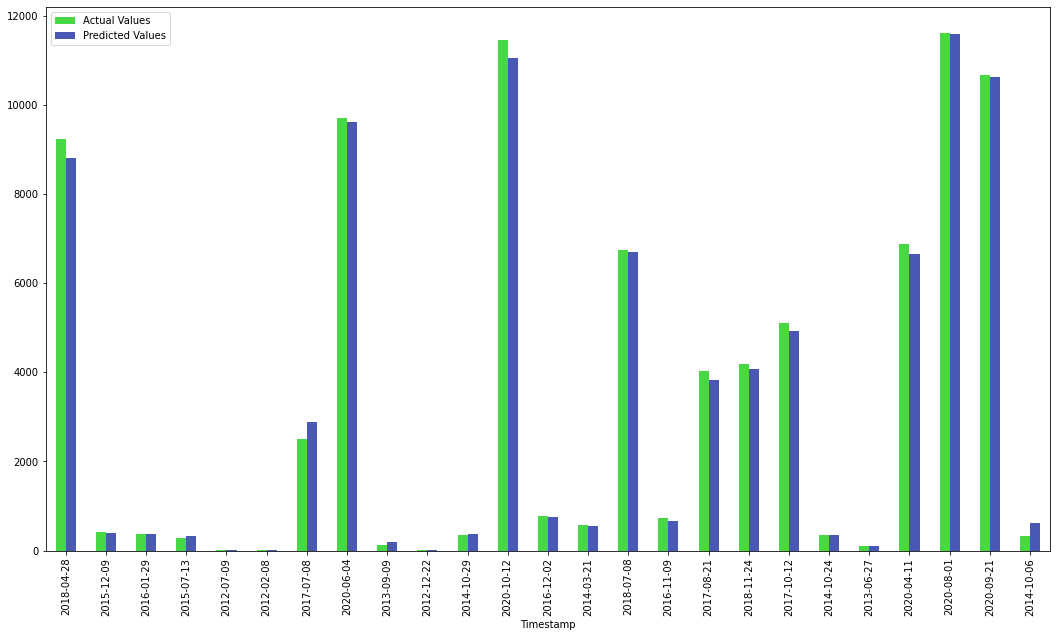

In [16]:
knn_plot=pd.DataFrame({'Actual Values':y_test,'Predicted Values':predicted_y})
knn_plot.tail(25).plot(kind='bar',figsize=(18,10), color=['#49D845', '#4958B5'])
plt.show()

##### **3) Random Forest Classifier**

In [17]:
random_forest_frame=btc_main
random_forest_frame["Diff"] = random_forest_frame.Close.diff()
random_forest_frame["Force_Index"] = random_forest_frame["Close"] * random_forest_frame["Volume_BTC"]
random_forest_frame["y"]=random_forest_frame['Trade_signal']

In [18]:
random_forest_frame=random_forest_frame[['SMA10', 'Force_Index', 'y']].copy().dropna()

In [19]:
random_forest_frame.columns

Index(['SMA10', 'Force_Index', 'y'], dtype='object')

In [20]:
random_forest_frame

,SMA10,Force_Index,y
Timestamp,,,
2012-01-09,5.819,11.7180,0.0
2012-01-10,6.075,14.8512,0.0
2012-01-11,6.275,15.3300,0.0
2012-01-12,6.426,44.6586,0.0
2012-01-13,6.557,10.0980,0.0
...,...,...,...
2021-03-27,55420.714,101627.7444,1.0
2021-03-28,55235.001,80896.8340,1.0
2021-03-29,55187.811,214848.3730,1.0


In [21]:
X = random_forest_frame.drop(["y"], axis=1).values
y = random_forest_frame["y"].values
# Split 85:15 for train test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,shuffle=False)

In [22]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train,y_train,)

RandomForestClassifier()

In [23]:
y_pred = random_forest_classifier.predict(X_test)
print("Accuracy for RFC: ",accuracy_score(y_test, y_pred)*100,"%")

Accuracy for RFC:  65.47619047619048 %


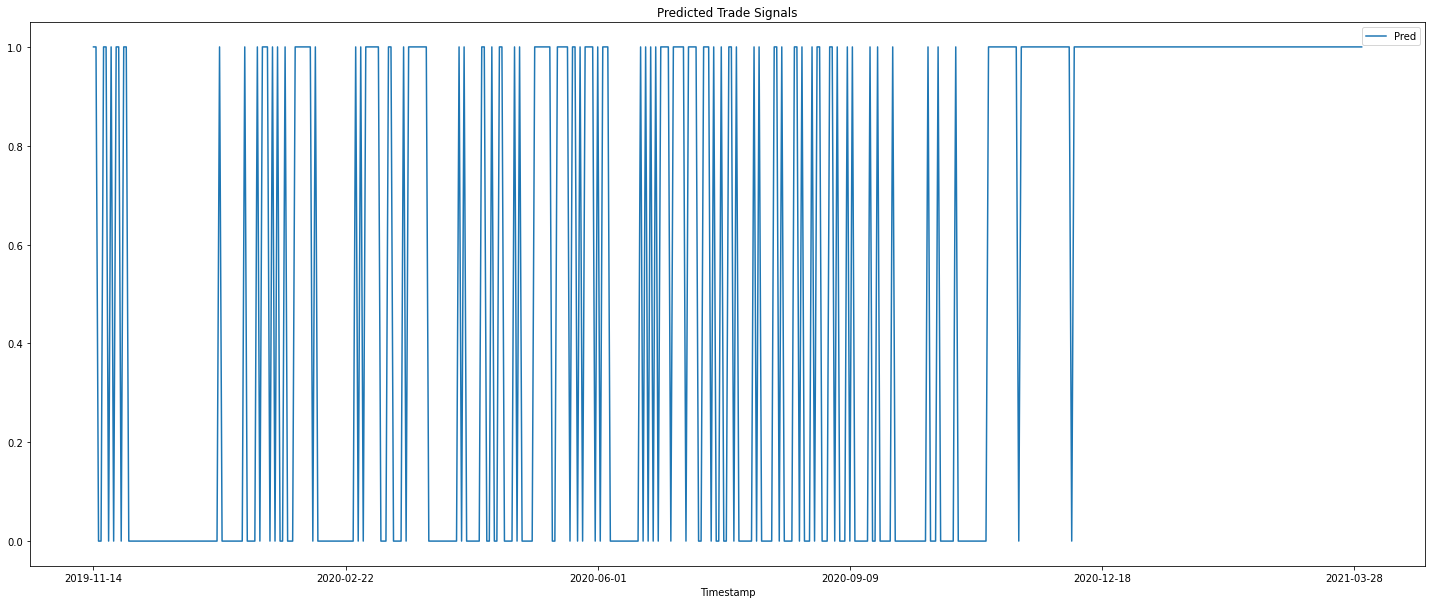

In [24]:
predictions=pd.DataFrame(y_pred)
predictions.columns=['Pred']
predictions.index=random_forest_frame[int(len(random_forest_frame)*0.85):].index
predictions.plot(figsize=(25,10), title='Predicted Trade Signals')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


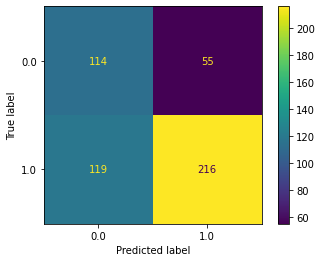

In [25]:
plot_confusion_matrix(random_forest_classifier, X_test, y_test) 

##### **4) Long Short Term Memory (LSTM)**

In [26]:
# Splitting the dataset
splitting_index = int(0.85*len(btc_data))
training_df = btc_data.iloc[:splitting_index,:]
testing_df = btc_data.iloc[splitting_index:,:]

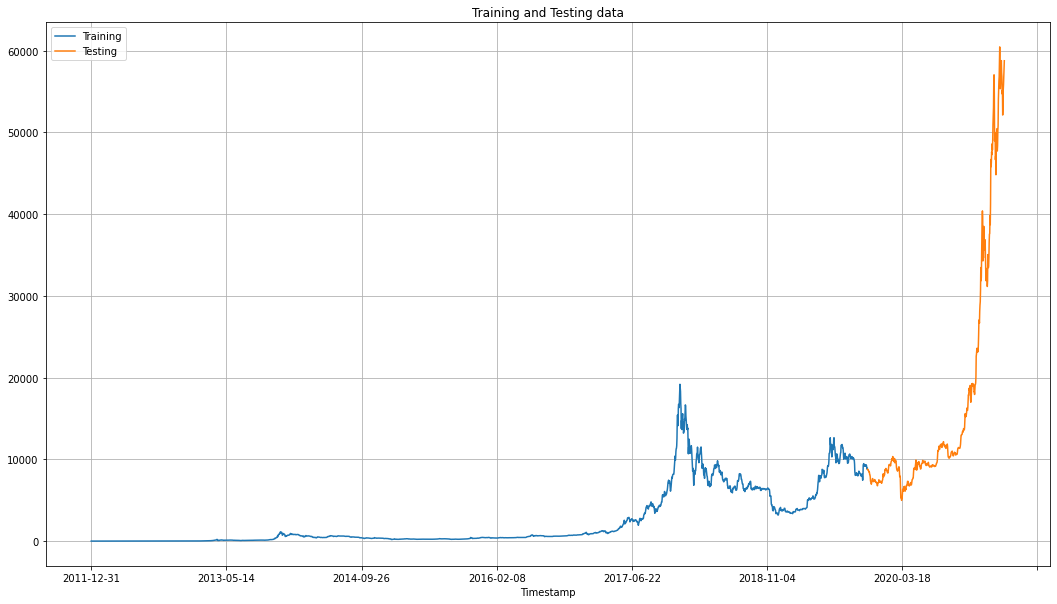

In [27]:
# Visualize Training and Testing data
visualize_frame=pd.DataFrame({})
visualize_frame.index=btc_data.index
visualize_frame['Training']=training_df['Weighted_Price']
visualize_frame['Testing']=testing_df['Weighted_Price']
visualize_frame.plot(grid=True, figsize=(18,10), title='Training and Testing data')

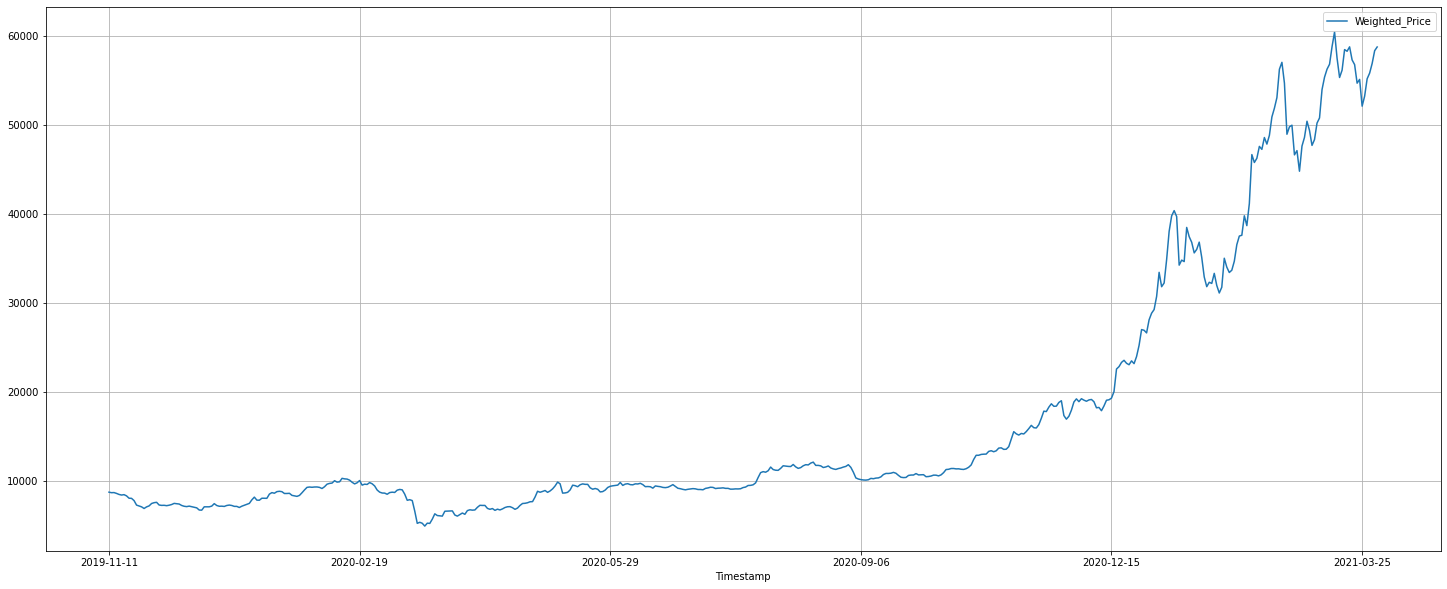

In [28]:
testing_df.plot(grid=True, figsize=(25,10))

In [29]:
training_set = training_df.values
training_set = np.reshape(training_set, (len(training_set), 1))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)

X_train = training_set[:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [30]:
lstm_model = Sequential()

lstm_model.add(LSTM(units = 128, activation = 'sigmoid', input_shape = (1, 1)))

lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units = 1))

lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

lstm_model.summary()

model_history = lstm_model.fit(X_train, y_train, batch_size = 50, epochs = 100, verbose = 2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
58/58 - 5s - loss: 0.0823 - 5s/epoch - 79ms/step
Epoch 2/100
58/58 - 1s - loss: 0.0647 - 548ms/epoch - 9ms/step
Epoch 3/100
58/58 - 0s - loss: 0.0561 - 498ms/epoch - 9ms/step
Epoch 4/100
58/58 - 0s - loss: 0.0489 - 484ms/epoch - 8ms/step
Epoch 5/100
58/58 - 0s - loss: 0.0412 - 374ms/epoch - 6ms/step
Epo

In [31]:
# Making the predictions
test_set = testing_df.values
test_x = np.reshape(test_set, (len(test_set), 1))
test_x = sc.transform(test_x)
test_x = np.reshape(test_x, (len(test_x), 1, 1))
predicted_BTC_price = lstm_model.predict(test_x)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
testing_df['Weighted_Price_Prediction'] = predicted_BTC_price

16/16 [==============================] - 0s 4ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


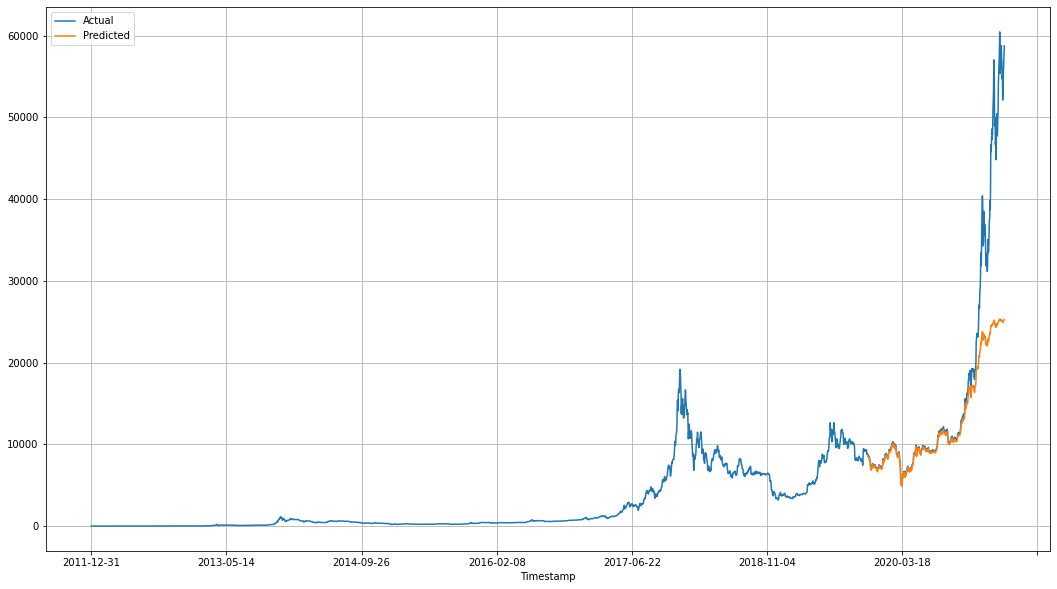

In [32]:
# Visualize results
visualize_frame=pd.DataFrame({})
visualize_frame.index=btc_data.index
visualize_frame['Actual']=btc_data['Weighted_Price']
visualize_frame['Predicted']=testing_df['Weighted_Price_Prediction']
visualize_frame.plot(grid=True, figsize=(18,10))

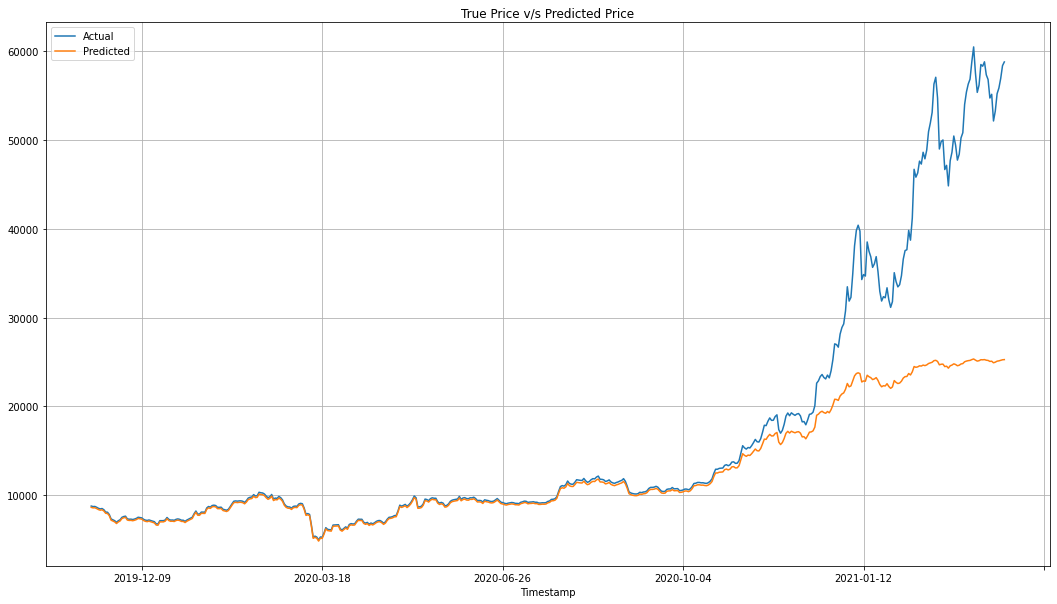

In [33]:
# A closer look

visualize_frame=pd.DataFrame({})
visualize_frame.index=btc_data.index
visualize_frame['Actual']=testing_df['Weighted_Price']
visualize_frame['Predicted']=testing_df['Weighted_Price_Prediction']
visualize_frame.plot(grid=True, figsize=(18,10), title='True Price v/s Predicted Price')

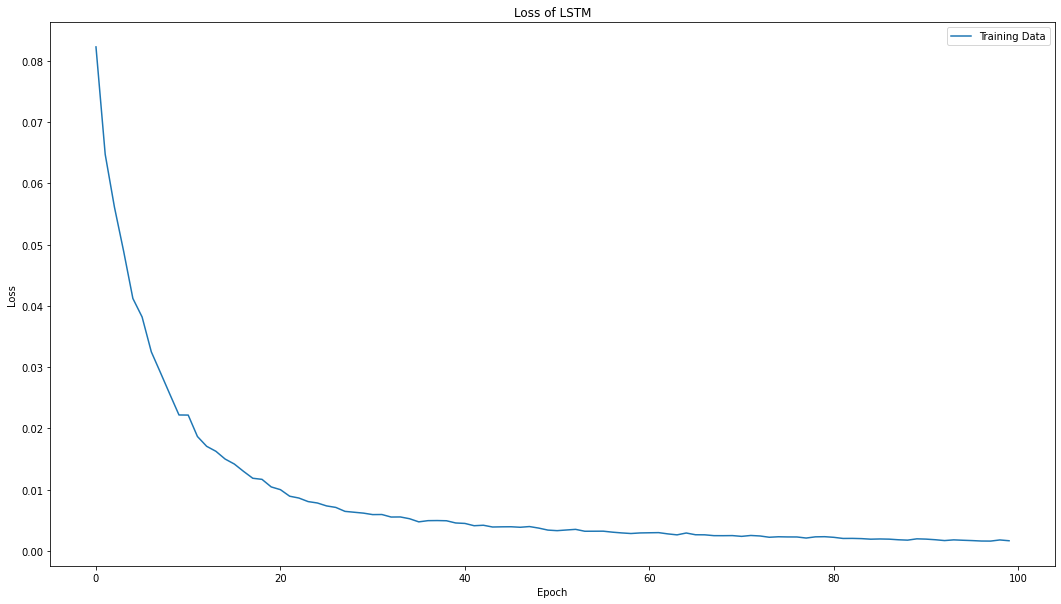

In [34]:
# Model's loss evaluation
plt.figure(figsize=(18,10))
plt.plot(model_history.history['loss'])
plt.legend(['Training Data'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss of LSTM')
plt.show()

##### **5) FB Prophet**

In [35]:
prophet_data=btc_main.copy()
prophet_data

,Open,Close,High,Low,Volume_BTC,Volume_Currency,Weighted_Price,Change_percentage,SMA10,SMA20,SMA50,Trade_signal,Diff,Force_Index,y
Timestamp,,,,,,,,,,,,,,,
2011-12-31,4.39,4.58,4.58,4.39,23.83,106.33,4.47,NaN,NaN,NaN,NaN,0.0,NaN,109.1414,0.0
2012-01-01,4.58,5.00,5.00,4.58,7.20,35.26,4.81,9.17,NaN,NaN,NaN,0.0,0.42,36.0000,0.0
2012-01-02,5.00,5.00,5.00,5.00,19.05,95.24,5.00,0.00,NaN,NaN,NaN,0.0,0.00,95.2500,0.0
2012-01-03,5.32,5.29,5.32,5.14,11.00,58.10,5.25,5.80,NaN,NaN,NaN,0.0,0.29,58.1900,0.0
2012-01-04,4.93,5.57,5.57,4.93,11.91,63.12,5.21,5.29,NaN,NaN,NaN,0.0,0.28,66.3387,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,55081.26,55839.42,56686.15,53948.35,1.82,100884.73,55193.36,1.38,55420.714,56204.7735,51692.5584,1.0,758.05,101627.7444,1.0
2021-03-28,55817.85,55790.92,56573.04,54677.51,1.45,80632.12,55832.96,-0.09,55235.001,56372.9295,52022.7348,1.0,-48.50,80896.8340,1.0
2021-03-29,55790.28,57600.10,58402.68,54892.42,3.73,213754.56,56913.99,3.24,55187.811,56506.4835,52397.5690,1.0,1809.18,214848.3730,1.0


In [36]:
prophet_data.reset_index(inplace=True)
prophet_data = prophet_data[['Timestamp', 'Weighted_Price']]
prophet_data.columns = ['ds', 'y']

In [37]:
# Splitting the dataset
size = int(len(prophet_data) * 0.85)
train = prophet_data[:size]
test = prophet_data[size:]

In [38]:
prophet_model = Prophet()
prophet_model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [39]:
future_frame = prophet_model.make_future_dataframe(periods=len(test))
forecasting = prophet_model.predict(future_frame)
y_true = test['y'].values
y_pred = forecasting.yhat.values[-len(test):]

In [40]:
forecasting

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-12-31,-66.887553,-1408.777337,1655.640726,-66.887553,-66.887553,211.265964,211.265964,211.265964,9.843689,9.843689,9.843689,201.422275,201.422275,201.422275,0.0,0.0,0.0,144.378411
1,2012-01-01,-66.354882,-1431.674243,1626.142008,-66.354882,-66.354882,173.559564,173.559564,173.559564,0.388747,0.388747,0.388747,173.170817,173.170817,173.170817,0.0,0.0,0.0,107.204683
2,2012-01-02,-65.822210,-1511.001288,1586.320020,-65.822210,-65.822210,151.764376,151.764376,151.764376,6.156795,6.156795,6.156795,145.607581,145.607581,145.607581,0.0,0.0,0.0,85.942166
3,2012-01-03,-65.289539,-1553.505228,1498.325548,-65.289539,-65.289539,125.709875,125.709875,125.709875,6.768856,6.768856,6.768856,118.941019,118.941019,118.941019,0.0,0.0,0.0,60.420337
4,2012-01-04,-64.756867,-1489.534925,1556.145209,-64.756867,-64.756867,93.304759,93.304759,93.304759,-0.012928,-0.012928,-0.012928,93.317687,93.317687,93.317687,0.0,0.0,0.0,28.547892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3374,2021-03-27,8906.804155,371.860719,16022.213794,558.692421,16456.058608,-406.446434,-406.446434,-406.446434,9.843689,9.843689,9.843689,-416.290122,-416.290122,-416.290122,0.0,0.0,0.0,8500.357722
3375,2021-03-28,8909.031002,284.080716,15908.671026,528.266595,16508.595743,-407.081419,-407.081419,-407.081419,0.388747,0.388747,0.388747,-407.470166,-407.470166,-407.470166,0.0,0.0,0.0,8501.949582
3376,2021-03-29,8911.257848,-94.505152,16078.899203,501.517944,16552.525028,-390.302571,-390.302571,-390.302571,6.156795,6.156795,6.156795,-396.459366,-396.459366,-396.459366,0.0,0.0,0.0,8520.955277
3377,2021-03-30,8913.484694,311.923310,16251.697416,474.909228,16571.894658,-376.734444,-376.734444,-376.734444,6.768856,6.768856,6.768856,-383.503300,-383.503300,-383.503300,0.0,0.0,0.0,8536.750250


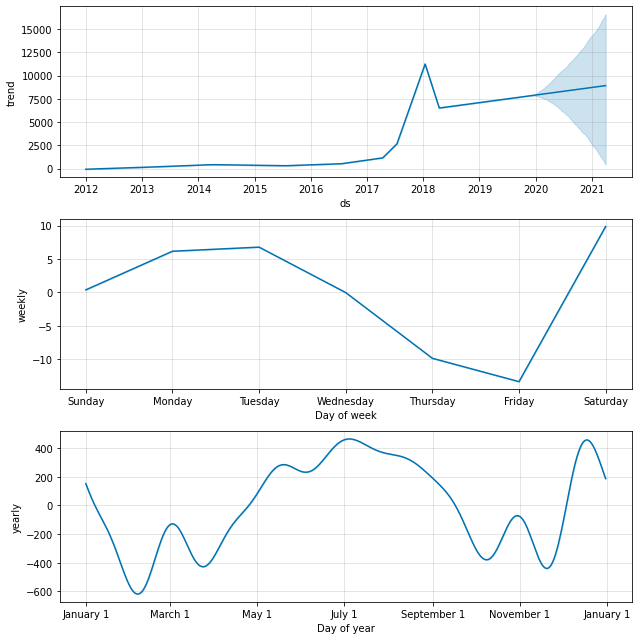

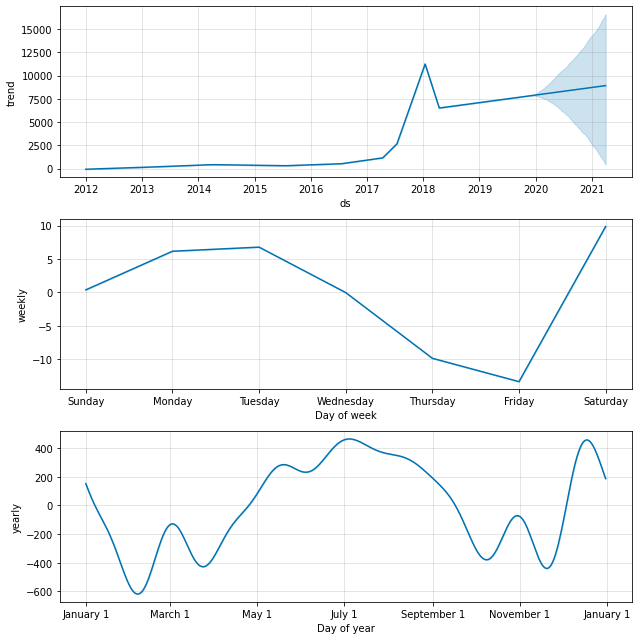

In [41]:
# Visualize model components
prophet_model.plot_components(forecasting)

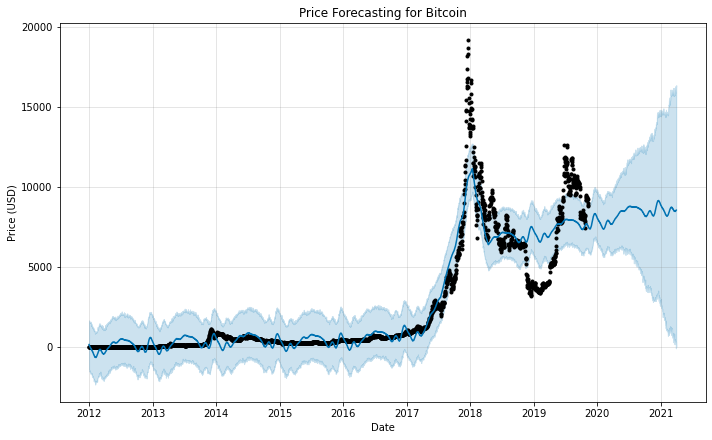

In [42]:
# Visualizing results
prophet_model.plot(forecasting)
plt.title('Price Forecasting for Bitcoin')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.show()

In [43]:
# model evaluation using RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 16437.500
